# Visualising outbreak curves

## Reading and cleaning  the data

Import things

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import os
import pylab as plt
import geopandas as gpd
import adjustText as aT
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [2]:
from os.path import isfile, join
#path = '/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/output/'
#path_raw = '/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/raw/'

path = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/"
path_raw = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/raw/"
path_raw_input = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\raw/"
path_output = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/direct_output/"

COMPARE TO [this](https://ourworldindata.org/covid-deaths)

## 1. Plotting the Ordering of Districts

### Observing while running

Progress can be observed as they're running - just add the file to which the simulation is exporting below!

**NOTE: MAKE SURE YOU HAVE A TEXT FILE IN THE SAME DIRECTORY AS THIS FILE CONTAINING THE 'TRUE' ORDER OF FILES!**

This file should be formatted as follows:

```
day	districtId
1	1
1	2
...
```

Please note that it is TAB DELIMITED - if your data is not, then you will need to update the csv readin below.

In [40]:
# set my path when running the file from here


# read and clean the data
results_filename = (path_output+'exportMe9927_03_180_swdata_server_v2.txt')
r_data = pd.read_csv(results_filename, sep='\t')
r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]] # she is renaming districtid myId
r_data.head()

,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,Unnamed: 8,districtId
0,0,d_38,0,0,0,0,0,0,NaN,38
1,0,d_39,0,0,0,0,0,0,NaN,39
2,0,d_47,0,0,0,0,0,0,NaN,47
3,0,d_48,0,0,0,0,2,0,NaN,48
4,0,d_45,0,0,0,0,0,0,NaN,45


In [41]:
r_data.describe()

,time,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,Unnamed: 8,districtId
count,10800.000000,10800.000000,10800.000000,10800.000000,10800.000000,10800.000000,10800.000000,0.0,10800.000000
mean,89.500000,0.042407,0.014537,0.003056,0.210278,0.376574,0.000926,NaN,30.500000
std,51.963128,0.246576,0.128645,0.055195,0.764129,1.243391,0.030416,NaN,17.318904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000
25%,44.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,15.750000
50%,89.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,30.500000
75%,134.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,45.250000
max,179.000000,2.000000,3.000000,1.000000,11.000000,19.000000,1.000000,NaN,60.000000


In [42]:

# filter out case data
cases = r_data[(r_data.metric_new_cases_sympt > 0) | (r_data.metric_new_cases_asympt > 0)]
cases.head()

# group by districts and sort by time
byDistric = cases.groupby('districtId').agg({'time': 'min'})
byDistric.sort_values(by="time")

# sophie adding want to rename 'time' to denote the day of simulation
byDistric.rename(columns={'time':'simDay'}, inplace=True)

byDistric.head()

# read in the first districts cases data (what she called 'gold standard data')
gold_filename = (path+"../preprocessed/line_list/true.txt")
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']] ## Sophie not using this 

# join the simulated and gold standard data based on the district ID
comparison = g_data.join(byDistric, on='districtId', lsuffix='_gold', rsuffix='_sim')
comparison['simDay'] = comparison['simDay'].fillna(0) # you may wish to set the unfound districts to some default
comparison['trueDay']= comparison['trueDay'].fillna(0)
#comparison # show the results
comparison.head()
comparison.to_csv(path+'comparison.csv')

In [43]:
myslice = pd.isna(comparison['simDay']) # see all of the districts where there were cases in both sim and true days 
#print(comparison[-myslice]) # showing the districts where the cases occured in both simulation and true data
both_sa= comparison[-myslice]
myslice.head()

0    False
1    False
2    False
3    False
4    False
Name: simDay, dtype: bool

C:\Users\wb488473\Anaconda3\envs\covid19_abm\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


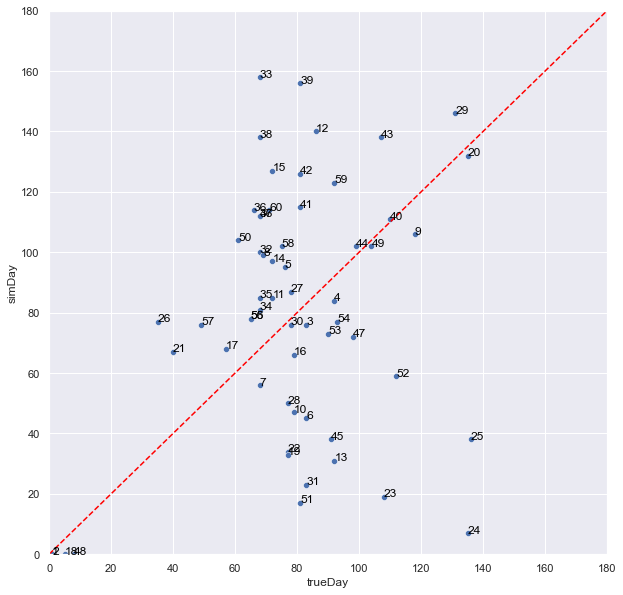

In [58]:
fig, ax = plt.subplots (figsize = (10,10))
ax= sns.scatterplot(
             x="trueDay", 
             y="simDay",
             #y="metric_new_hospitalized",
             #y="metric_new_cases_sympt", 
             palette="colorblind", 
            # hue="districtId",
             data=comparison, #,
            #legend=True
            )
            #.legend(bbox_to_anchor= (1.03, 1) )
            
 # add labels to values on product id
for line in range(0,comparison.shape[0]):
    ax.text(comparison.trueDay[line] +0.01, comparison.simDay[line],
           comparison.districtId[line], horizontalalignment='left',
           size='medium', color='black', weight ='light')

ax.set(xlim=(0, 180), ylim=(0, 180)) # in true day the max first day is 136, in sim the max first day is 179
xl, yl = [0,180], [0,180]
sns.lineplot(xl, yl, linestyle='--', color='red')


plt.savefig(path+'plots/sim_vs_true_firstcases_03_180_swdata_server_v2.png', dpi=300,  facecolor='w', edgecolor='w', transparent=True)



In [ ]:
#convert points to format that can be plotted for Rsquared calculation
x=comparison['trueDay']
x.to_dict()
y=comparison['simDay']
y.to_dict()

# plot with R-Squared

plt.scatter(x,y)

#fit the line 
model = np.polyfit(x,y,1)
model
predict = np.poly1d(model)
r2_score(y, predict(x))
# pretty poor rsquared at present 

In [ ]:
#visualize the plot
x_lin_reg = range(0,140)
y_lin_reg = predict(x_lin_reg)
plt.scatter(x,y, color='blue')
plt.plot(x_lin_reg, y_lin_reg, c='r')

### 4. Visualize the actual case data versus the model simulation

In [45]:
from os.path import isfile, join
gd_path = '/Users/sophieayling/Google Drive/PhD/10_validation/'
gh_path = '/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\calibration_data/'

In [46]:
# import the data
df_cases = pd.read_stata(gh_path + 'national_cases_by_day.dta')
df_deaths = pd.read_stata(gh_path + 'national_deaths_by_day.dta')
df_deaths.head()

,date,deaths_by_day
0,2020-03-20,1.0
1,2020-03-24,0.0
2,2020-03-25,0.0
3,2020-03-27,0.0
4,2020-03-30,0.0


In [47]:
real_data= df_cases.set_index('date').join(df_deaths.set_index('date'))


# create a date range including each day and match back to this
all_dates= pd.date_range(start='2020-03-20', end='2020-09-01')
all_dates= all_dates.to_frame(index=True, name ='dated')
all_dates.index.name = 'date'
#all_dates.head()
#real_data.head()
real_data=real_data.reset_index()
real_data.head()
real_data.to_csv(path_output+'real_data_comb.csv')

In [48]:
comb_data=all_dates.join(real_data.set_index('date'), on='date')
comb_data = comb_data.fillna(0)
comb_data['cum_deaths']=comb_data['deaths_by_day'].cumsum()
comb_data=comb_data.drop(columns=['dated'])
comb_data=comb_data.reset_index()
comb_data.head()
comb_data.to_csv(path_output+'comb_data.csv')


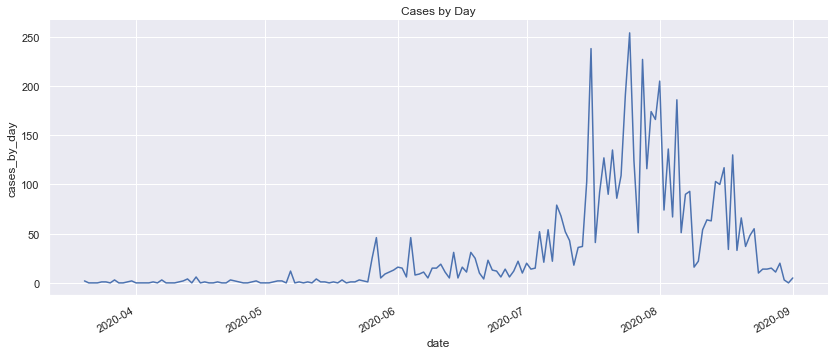

In [49]:
# take a look at case data

g=sns.relplot(x="date", y="cases_by_day", kind="line", data=comb_data).set(title="Cases by Day")
g.fig.set_figwidth(13,4)
g.fig.autofmt_xdate()

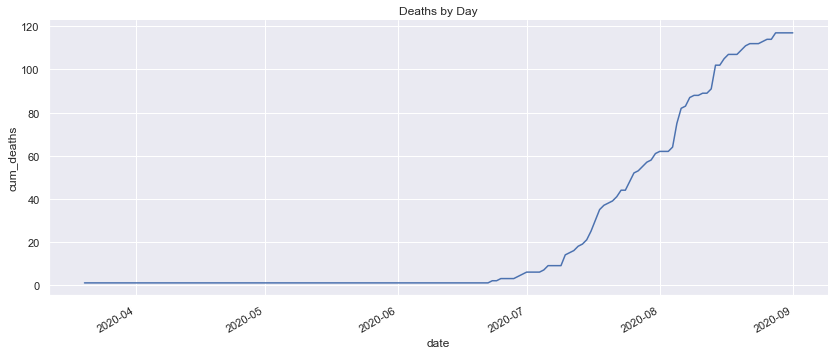

In [50]:
# take a look at death data
g = sns.relplot(x="date", y="cum_deaths", kind="line", data=comb_data).set(title="Deaths by Day")
g.fig.set_figwidth(13,4)
g.fig.autofmt_xdate()

In [51]:
r_data.head()

,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,Unnamed: 8,districtId
0,0,d_38,0,0,0,0,0,0,NaN,38
1,0,d_39,0,0,0,0,0,0,NaN,39
2,0,d_47,0,0,0,0,0,0,NaN,47
3,0,d_48,0,0,0,0,2,0,NaN,48
4,0,d_45,0,0,0,0,0,0,NaN,45


In [52]:
# create the national cases and cumulative deaths by day equivalent
nat_daily_sim = r_data.groupby(['time']).agg({'metric_new_cases_sympt':np.sum, 'metric_new_deaths':np.sum, 'metric_died_count':np.sum})
nat_daily_sim.head()
nat_daily_sim.to_csv(path_output+'nat_daily_sim.csv')
## need to figure out why metric_new_cases_sypt seems to be non cumulative but the other is cumulative

In [53]:
# join the real and sim data
real_plus_sim=nat_daily_sim.join(comb_data, lsuffix='_sim', rsuffix='real')

# create a scaled up variable of cases and deaths x20
real_plus_sim['scaled_sim_cases']=real_plus_sim['metric_new_cases_sympt'] *20
real_plus_sim['scaled_sim_deaths']=real_plus_sim['metric_new_deaths' ] *20


# create the cumulative variable for sim deaths
real_plus_sim['cum_deaths_sim']=real_plus_sim['metric_new_deaths'].cumsum()
real_plus_sim['cum_deaths_sim_scaled']=real_plus_sim['scaled_sim_deaths'].cumsum()


real_plus_sim= real_plus_sim[['date', 'cases_by_day', 'metric_new_cases_sympt', 'scaled_sim_cases', 'deaths_by_day', 'cum_deaths', 'metric_new_deaths', 'metric_died_count', 'scaled_sim_deaths', 'cum_deaths_sim', 'cum_deaths_sim_scaled']] 
real_plus_sim.to_csv(path_output+'real_plus_sim_03_180_swdata_server_v2.csv')
real_plus_sim.describe()

,cases_by_day,metric_new_cases_sympt,scaled_sim_cases,deaths_by_day,cum_deaths,metric_new_deaths,metric_died_count,scaled_sim_deaths,cum_deaths_sim,cum_deaths_sim_scaled
count,166.000000,180.000000,180.000000,166.000000,166.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,32.572289,22.594444,451.888889,0.704819,24.945784,0.055556,2.544444,1.111111,2.544444,50.888889
std,51.916286,26.852941,537.058811,1.656093,38.946625,0.229700,2.738760,4.594007,2.738760,54.775202
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,40.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.500000,12.500000,250.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.000000,40.000000
75%,42.500000,31.000000,620.000000,1.000000,40.500000,0.000000,4.000000,0.000000,4.000000,80.000000
max,254.000000,117.000000,2340.000000,11.000000,117.000000,1.000000,10.000000,20.000000,10.000000,200.000000


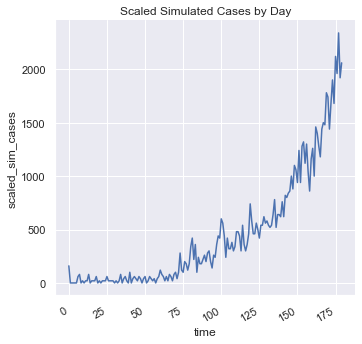

In [54]:
g = sns.relplot(x="time", y="scaled_sim_cases", kind="line", data=real_plus_sim).set(title="Scaled Simulated Cases by Day")
g.fig.autofmt_xdate()
g.savefig("../data/output/plots/sim_scaled_cases_03_180_swdata_server_v2.png")

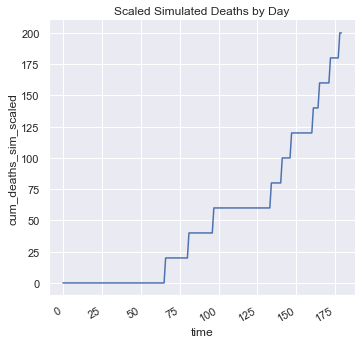

In [55]:
g = sns.relplot(x="time", y="cum_deaths_sim_scaled", kind="line", data=real_plus_sim).set(title="Scaled Simulated Deaths by Day")
g.fig.autofmt_xdate()
g.savefig("../data/output/plots/sim_scaled_deaths_03_180_swdata_server_v2.png")

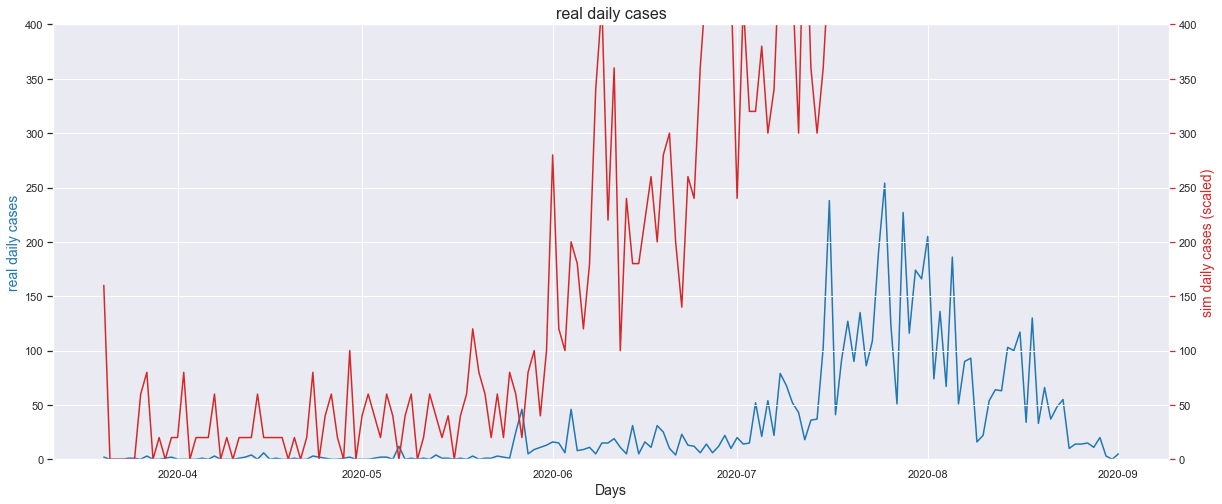

In [56]:

fig, ax1 = plt.subplots(figsize=(20,8))
color = 'tab:blue'
#real data creation
ax1.set_title('real daily cases', fontsize=16)
ax1.set_xlabel('Days', fontsize= 14)
ax1.set_ylabel('real daily cases', fontsize=14, color= color)
ax1= sns.lineplot(x='date', y='cases_by_day', data=real_plus_sim, ci=None, color=color, legend='auto')
ax1.tick_params(axis='y')
ax1.set_ylim([0,400])

#specify we want to share the same x axis
ax2 = ax1.twinx()

color = 'tab:red'
#line plot creation for sim data
ax2.set_ylabel('sim daily cases (scaled)', fontsize=14, color=color)
ax2 = sns.lineplot(x='date', y='scaled_sim_cases', data=real_plus_sim, ci=None, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
ax2.set_ylim([0,400])
#show plot
fig.savefig("../data/output/plots/sim_scaled_plus_real_cases_03_180_swdata_server_v2.png")

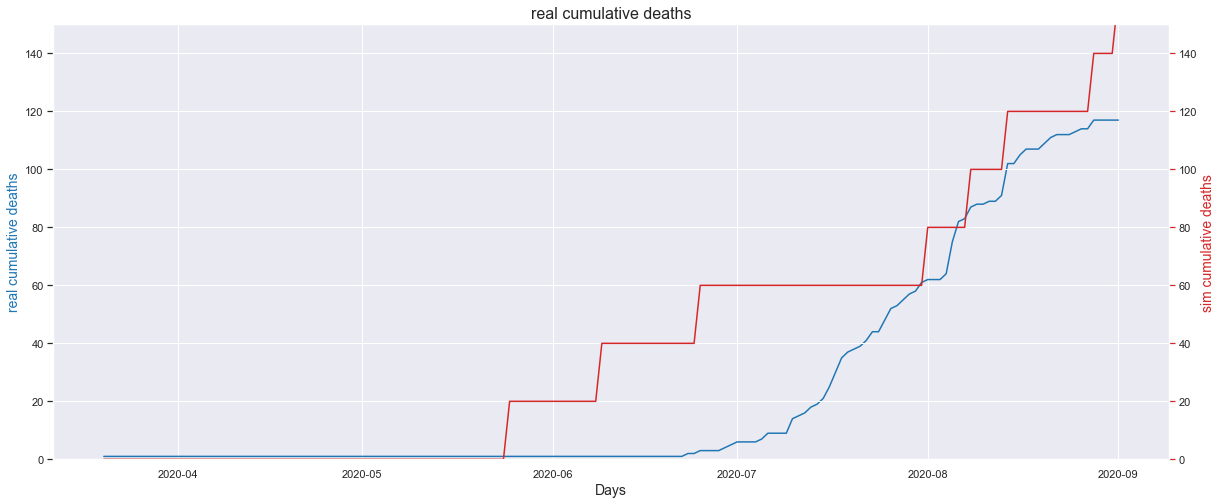

In [57]:
# Same type of plot for cumulative deaths in sim versus reality

fig, ax1 = plt.subplots(figsize=(20,8))
color = 'tab:blue'
#real data creation
ax1.set_title('real cumulative deaths', fontsize=16)
ax1.set_xlabel('Days', fontsize= 14)
ax1.set_ylabel('real cumulative deaths', fontsize=14, color= color)
ax1= sns.lineplot(x='date', y='cum_deaths', data=real_plus_sim, ci=None, color=color, legend='auto')
ax1.tick_params(axis='y')
ax1.set_ylim([0,150])

#specify we want to share the same x axis
ax2 = ax1.twinx()

color = 'tab:red'
#line plot creation for sim data
ax2.set_ylabel('sim cumulative deaths', fontsize=14, color=color)
ax2 = sns.lineplot(x='date', y='cum_deaths_sim_scaled', data=real_plus_sim, ci=None, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
ax2.set_ylim([0,150])
#show plot
fig.savefig("../data/output/plots/sim_plus_real_deaths_03_180_swdata_server_v2.png")